In [802]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from xgboost import XGBClassifier
import pickle

# Базовый датафрейм

In [323]:
target_events = ["P1 <= 0",
                "P2 <= 0",
                "T1 > max",
                "T1 < min",
                "Авария",
                "Недостаточная температура подачи в центральном отоплении (Недотоп)",
                "Превышение температуры подачи в центральном отоплении (Перетоп)",
                "Утечка теплоносителя",
                "Температура в квартире ниже нормативной",
                "Отсутствие отопления в доме",
                "Крупные пожары",
                "Температура в помещении общего пользования ниже нормативной",
                "Аварийная протечка труб в подъезде",
                "Протечка труб в подъезде",
                "Течь в системе отопления",
                "Сильная течь в системе отопления"]

In [324]:
df_autumn = pd.read_csv("../data/events_autumn/events.csv", delimiter=';')
df_spring = pd.read_csv("../data/events_spring/events.csv", delimiter=';')
# rename columns to easily access them
df_autumn.columns = ["event", "source", "date_registry", "date_close", "district", "unom", "address", "datetime_finish_event"]
df_spring.columns = ["event", "source", "date_registry", "date_close", "district", "unom", "address", "datetime_finish_event"]
events_df = pd.concat([df_autumn, df_spring])
events_df["date_registry"] = pd.to_datetime(events_df["date_registry"]).dt.date
events_df["date_close"] = pd.to_datetime(events_df["date_close"]).dt.date
events_df = events_df[events_df.event.isin(target_events)].drop(columns=["district", "address", "source", "datetime_finish_event"])
events_df = events_df[["unom", "event", "date_registry", "date_close"]]

In [325]:
building_info_df = pd.read_excel("../raw/9. Выгрузка БТИ.xlsx", skiprows=1)
building_info_df = building_info_df[["Unnamed: 11", "Материал", "Назначение", "Класс"]]
building_info_df.columns = ["unom", "material", "purpose", "class"]

In [507]:
building_characteristics_df = pd.read_excel("../raw/14. ВАО_Многоквартирные_дома_с_технико_экономическими_характеристиками.xlsx", skiprows=1)
building_characteristics_df = building_characteristics_df[["УНОМ", "Количество этажей", "Количество квартир", "Общая площадь", "Износ объекта (по БТИ)"]]
building_characteristics_df.columns = ["unom", "floor_num", "flat_num", "square", "damage_rate"]
building_characteristics_df.index = building_characteristics_df.unom
building_characteristics_df = building_characteristics_df.drop(columns=["unom"])

In [326]:
districts_df = pd.read_csv("../data/11_chauffage.csv")
# df11 = df11[["UNOM", "Район", "Месяц/Год", "Объём поданого теплоносителя в систему ЦО", "Объём обратного теплоносителя из системы ЦО",
#       "Разница между подачей и обраткой(Подмес)", "Разница между подачей и обраткой(Утечка)", "Температура подачи",
#       "Температура обратки", "Наработка часов счётчика", "Расход тепловой энергии ", "Ошибки"]]
districts_df = districts_df[["UNOM", "Район"]]
districts_df = districts_df[["UNOM", "Район"]].drop_duplicates()
districts_df.columns = ["unom", "district"]

In [327]:
df = pd.merge(events_df, building_info_df, how="left")
df = df.merge(districts_df, how="left")

In [508]:
df.head()

,unom,event,date_registry,date_close,material,purpose,class,district
0,8171,Температура в квартире ниже нормативной,2023-10-08,2023-10-08,кирпичные,многоквартирный дом,жилые,Преображенское
1,8171,Температура в квартире ниже нормативной,2023-10-08,2023-10-08,кирпичные,многоквартирный дом,жилые,Преображенское
2,8171,Температура в квартире ниже нормативной,2023-10-09,2023-10-09,кирпичные,многоквартирный дом,жилые,Преображенское
3,8171,Температура в квартире ниже нормативной,2023-10-09,2023-10-09,кирпичные,многоквартирный дом,жилые,Преображенское
4,8171,Температура в квартире ниже нормативной,2023-10-27,2023-10-27,кирпичные,многоквартирный дом,жилые,Преображенское


# Бинарный классификатор для каждого события отдельно
* на большом кол-ве событий - модель
* на малом могут быть правила

In [735]:
# 1. Данные для одного события
df["unom"] = df["unom"].astype("int")
df_bin = df[df.event == "Температура в квартире ниже нормативной"]
df_bin["label"] = 1

# 2. Добавить домов, у которых этого события не было
# В 11 приложении есть все дома из ВАО, у которых было отопление
no_event_df = districts_df[~districts_df.unom.isin(df_bin.unom.unique())]

# 3. Нужно подготовить те же признаки
# Пусть для начала это будут характеристики дома из 9 приложения
no_event_df = no_event_df.merge(building_info_df, how="left")
no_event_df["label"] = 0

# 4. Объединить в общий датафрейм
event_df = df_bin[["unom", "district", "material", "purpose", "class", "label"]]
event_df = event_df.drop_duplicates()
merge_df = pd.concat([event_df, no_event_df])

merge_df.index = merge_df.unom.astype(int)
merge_df = merge_df.drop(columns=["unom"])

/var/folders/3h/dhhfcbhd3pl2ss8czvd22c080000gn/T/ipykernel_13555/459412788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin["label"] = 1


In [697]:
number_of_events_per_building = df_bin.groupby("unom")[["event"]].count()
number_of_events_per_building.columns = ["event_cnt"]
# try:
merge_df = merge_df.join(number_of_events_per_building, how="left")
# except:
#     pass
merge_df["event_cnt"] = merge_df["event_cnt"].fillna(0)
merge_df.loc[merge_df["event_cnt"] == 0, "event_cnt_cat"] = 1
merge_df.loc[(merge_df["event_cnt"] >= 1) & (merge_df["event_cnt"] < 15), "event_cnt_cat"] = 2
merge_df.loc[merge_df["event_cnt"] >= 15, "event_cnt_cat"] = 3
merge_df = merge_df.drop(columns=["event_cnt"])

merge_df = merge_df.join(building_characteristics_df, how="left")
merge_df["floor_num"] = merge_df["floor_num"].fillna(merge_df["floor_num"].mean().astype(int))
merge_df["flat_num"] = merge_df["flat_num"].fillna(merge_df["flat_num"].mean().astype(int))
merge_df["square"] = merge_df["square"].fillna(merge_df["square"].mean().astype(int))
merge_df["damage_rate"] = merge_df["damage_rate"].fillna(df14_filtered["damage_rate"].mean().astype(int))

## Бинарный классификатор

In [763]:
X, y = merge_df[merge_df.columns[4:6]], merge_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

### Label Encoder

In [753]:
def preprocess_data(df):
    label_encoder = LabelEncoder()
    for col_name in ['district', 'material', 'purpose', 'class']:
        df[col_name] = df[col_name].fillna("NaN")
        df[col_name] = df[col_name].astype("category")
        df[col_name] = label_encoder.fit_transform(df[col_name])
    try:
        df = df.drop(columns=["unom"])
    except:
        pass
    return df
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

KeyError: 'district'

In [783]:
bst = XGBClassifier(n_estimators=50, max_depth=2, learning_rate=0.01)
bst.fit(X_train, y_train)
bst.score(X_test, y_test)

1.0

In [784]:
bst.predict_proba(X_test)

array([[0.14136308, 0.8586369 ],
       [0.14136308, 0.8586369 ],
       [0.53540933, 0.46459067],
       ...,
       [0.14136308, 0.8586369 ],
       [0.14136308, 0.8586369 ],
       [0.53540933, 0.46459067]], dtype=float32)

In [786]:
merge_df

,district,material,purpose,class,label
unom,,,,,
8171,Преображенское,кирпичные,многоквартирный дом,жилые,1
18700,Измайлово,кирпичные,многоквартирный дом,жилые,1
64149,NaN,монолитные (ж-б),многоквартирный дом,жилые,1
21923,Богородское,кирпичные,многоквартирный дом,жилые,1
27117,Новогиреево,из железобетонных сегментов,многоквартирный дом,жилые,1
...,...,...,...,...,...
2115881,Восточное Измайлово,кирпичные,колледж,нежилые,0
2403094,Богородское,легкобетонные блоки с утеплением,школа,нежилые,0
2105312,Измайлово,кирпичные,нежилое,нежилые,0


In [797]:
y_pred_proba = bst.predict_proba(X_test)[:, 1]
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (ROC-AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

ValueError: feature_names mismatch: ['label'] ['district', 'material', 'purpose', 'class', 'event_cnt_cat', 'floor_num', 'flat_num', 'square']
expected label in input data
training data did not have the following fields: district, class, material, flat_num, floor_num, event_cnt_cat, purpose, square

In [665]:
print(classification_report(bst.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       1.00      1.00      1.00       768

    accuracy                           1.00       970
   macro avg       1.00      1.00      1.00       970
weighted avg       1.00      1.00      1.00       970



# Save model and data

In [838]:
with open("../models/classifier_forest_low_temp.pkl", "wb") as f:
    pickle.dump(cls, f)

In [704]:
X_train.to_csv("../shared_data/X_train.csv")
X_test.to_csv("../shared_data/X_test.csv")
y_train.to_csv("../shared_data/y_train.csv")
y_test.to_csv("../shared_data/y_test.csv")

# generate more feautures

In [502]:
# кол-во проишествий по дому
number_of_events_per_building = df_bin.groupby("unom")[["event"]].count()
number_of_events_per_building.columns = ["event_cnt"]
try:
    merge_df = merge_df.join(number_of_events_per_building, how="left")
except:
    pass
merge_df["event_cnt"] = merge_df["event_cnt"].fillna(0)
merge_df.loc[merge_df["event_cnt"] == 0, "event_cnt_cat"] = 1
merge_df.loc[(merge_df["event_cnt"] >= 1) & (merge_df["event_cnt"] < 15), "event_cnt_cat"] = 2
merge_df.loc[merge_df["event_cnt"] >= 15, "event_cnt_cat"] = 3
merge_df = merge_df.drop(columns=["event_cnt"])

merge_df = merge_df.join(building_characteristics_df, how="left")
merge_df["floor_num"] = merge_df["floor_num"].fillna(merge_df["floor_num"].mean().astype(int))
merge_df["flat_num"] = merge_df["flat_num"].fillna(merge_df["flat_num"].mean().astype(int))
merge_df["square"] = merge_df["square"].fillna(merge_df["square"].mean().astype(int))
merge_df["damage_rate"] = merge_df["damage_rate"].fillna(df14_filtered["damage_rate"].mean().astype(int))

In [505]:
merge_df

,district,material,purpose,class,label,event_cnt_cat,floor_num,flat_num,square,damage_rate
unom,,,,,,,,,,
8171,Преображенское,кирпичные,многоквартирный дом,жилые,1,2.0,5.0,80.0,5219.0,20.0
18700,Измайлово,кирпичные,многоквартирный дом,жилые,1,2.0,5.0,45.0,2745.5,20.0
64149,NaN,монолитные (ж-б),многоквартирный дом,жилые,1,3.0,18.0,128.0,8907.9,0.0
21923,Богородское,кирпичные,многоквартирный дом,жилые,1,3.0,9.0,128.0,7004.0,20.0
27117,Новогиреево,из железобетонных сегментов,многоквартирный дом,жилые,1,2.0,14.0,98.0,4258.1,20.0
...,...,...,...,...,...,...,...,...,...,...
2115881,Восточное Измайлово,кирпичные,колледж,нежилые,0,1.0,8.0,112.0,6062.0,20.0
2403094,Богородское,легкобетонные блоки с утеплением,школа,нежилые,0,1.0,8.0,112.0,6062.0,20.0
2105312,Измайлово,кирпичные,нежилое,нежилые,0,1.0,8.0,112.0,6062.0,20.0


In [470]:
building_characteristics_df.head()

,Адрес из сторонней системы,Адрес по БТИ,УНОМ,Округ,Район,Серии проектов,Количество этажей,Количество подъездов,Количество квартир,Общая площадь,...,Износ объекта (по БТИ),Материалы стен,Признак аварийности здания,Количество пассажирских лифтов,Количество грузопассажирских лифтов,Очередность уборки кровли,Материалы кровли по БТИ,Unnamed: 19,Типы жилищного фонда,Статусы МКД
0,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Новокосино, Суздальская ул., д. 24, к. 2","город Москва, Суздальская улица, дом 24, корпус 2",31783,Восточный административный округ,муниципальный округ Новокосино,2048785,14,3.0,130.0,9210.9,...,NaN,2048929,22728486,6.0,0.0,NaN,22289207.0,0.0,42875644,58761330
1,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Сокольники, ул. Сокольнический Вал, д. 4","город Москва, улица Сокольнический Вал, дом 4",24231,Восточный административный округ,муниципальный округ Сокольники,2048912,5,3.0,61.0,2806.9,...,NaN,179625090,22728486,0.0,0.0,22289162.0,22289201.0,0.0,42875644,58761330
2,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Новокосино, Новокосинская ул., д. 38, к. 2","город Москва, Новокосинская улица, дом 38, корпус 2",16560,Восточный административный округ,муниципальный округ Новокосино,2048777,17,2.0,128.0,9538.4,...,NaN,2048929,22728486,2.0,2.0,NaN,22289201.0,0.0,42875644,58761330
3,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Ивановское, Малый Купавенский пр-д, д. 1","город Москва, Малый Купавенский проезд, дом 1",12180,Восточный административный округ,муниципальный округ Ивановское,2048789,16,2.0,206.0,11502.2,...,NaN,179625089,22728486,2.0,2.0,NaN,22289201.0,0.0,42875644,58761330
4,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Измайлово, 5-я Парковая ул., д. 52","город Москва, 5-я Парковая улица, дом 52",18617,Восточный административный округ,муниципальный округ Измайлово,2048912,5,9.0,155.0,9140.0,...,NaN,179625102,22728486,0.0,0.0,22289162.0,22289205.0,0.0,42875644,58761330


# Total

In [805]:
def func():
    target_events = [
                    "P1 <= 0",
                    "P2 <= 0",
                    "T1 > max",
                    "T1 < min",
                    "Авария",
                    "Недостаточная температура подачи в центральном отоплении (Недотоп)",
                    "Превышение температуры подачи в центральном отоплении (Перетоп)",
                    "Утечка теплоносителя",
                    "Температура в квартире ниже нормативной",
                    "Отсутствие отопления в доме",
                    "Крупные пожары",
                    "Температура в помещении общего пользования ниже нормативной",
                    "Аварийная протечка труб в подъезде",
                    "Протечка труб в подъезде",
                    "Течь в системе отопления",
                    "Сильная течь в системе отопления"
    ]
    
    df_autumn = pd.read_csv("../data/events_autumn/events.csv", delimiter=';')
    df_spring = pd.read_csv("../data/events_spring/events.csv", delimiter=';')
    # rename columns to easily access them
    df_autumn.columns = ["event", "source", "date_registry", "date_close", "district", "unom", "address", "datetime_finish_event"]
    df_spring.columns = ["event", "source", "date_registry", "date_close", "district", "unom", "address", "datetime_finish_event"]
    events_df = pd.concat([df_autumn, df_spring])
    events_df["date_registry"] = pd.to_datetime(events_df["date_registry"]).dt.date
    events_df["date_close"] = pd.to_datetime(events_df["date_close"]).dt.date
    events_df = events_df[events_df.event.isin(target_events)].drop(columns=["district", "address", "source", "datetime_finish_event"])
    events_df = events_df[["unom", "event", "date_registry", "date_close"]]
    
    building_info_df = pd.read_excel("../raw/9. Выгрузка БТИ.xlsx", skiprows=1)
    building_info_df = building_info_df[["Unnamed: 11", "Материал", "Назначение", "Класс"]]
    building_info_df.columns = ["unom", "material", "purpose", "class"]
    
    building_characteristics_df = pd.read_excel("../raw/14. ВАО_Многоквартирные_дома_с_технико_экономическими_характеристиками.xlsx", skiprows=1)
    building_characteristics_df = building_characteristics_df[["УНОМ", "Количество этажей", "Количество квартир", "Общая площадь", "Износ объекта (по БТИ)"]]
    building_characteristics_df.columns = ["unom", "floor_num", "flat_num", "square", "damage_rate"]
    building_characteristics_df.index = building_characteristics_df.unom
    building_characteristics_df = building_characteristics_df.drop(columns=["unom"])
    
    districts_df = pd.read_csv("../data/11_chauffage.csv")
    districts_df = districts_df[["UNOM", "Район"]]
    districts_df = districts_df[["UNOM", "Район"]].drop_duplicates()
    districts_df.columns = ["unom", "district"]
    
    df = pd.merge(events_df, building_info_df, how="left")
    df = df.merge(districts_df, how="left")
    
    # 1. Данные для одного события
    df["unom"] = df["unom"].astype("int")
    df_bin = df[df.event == "Температура в квартире ниже нормативной"]
    df_bin["label"] = 1
    
    # 2. Добавить домов, у которых этого события не было
    # В 11 приложении есть все дома из ВАО, у которых было отопление
    no_event_df = districts_df[~districts_df.unom.isin(df_bin.unom.unique())]
    
    # 3. Нужно подготовить те же признаки
    # Пусть для начала это будут характеристики дома из 9 приложения
    no_event_df = no_event_df.merge(building_info_df, how="left")
    no_event_df["label"] = 0
    
    # 4. Объединить в общий датафрейм
    event_df = df_bin[["unom", "district", "material", "purpose", "class", "label"]]
    event_df = event_df.drop_duplicates()
    merge_df = pd.concat([event_df, no_event_df])
    
    merge_df.index = merge_df.unom.astype(int)
    merge_df = merge_df.drop(columns=["unom"])
    
    number_of_events_per_building = df_bin.groupby("unom")[["event"]].count()
    number_of_events_per_building.columns = ["event_cnt"]
    merge_df = merge_df.join(number_of_events_per_building, how="left")
    merge_df["event_cnt"] = merge_df["event_cnt"].fillna(0)
    merge_df.loc[merge_df["event_cnt"] == 0, "event_cnt_cat"] = 1
    merge_df.loc[(merge_df["event_cnt"] >= 1) & (merge_df["event_cnt"] < 15), "event_cnt_cat"] = 2
    merge_df.loc[merge_df["event_cnt"] >= 15, "event_cnt_cat"] = 3
    merge_df = merge_df.drop(columns=["event_cnt"])
    
    merge_df = merge_df.join(building_characteristics_df, how="left")
    merge_df["floor_num"] = merge_df["floor_num"].fillna(merge_df["floor_num"].mean().astype(int))
    merge_df["flat_num"] = merge_df["flat_num"].fillna(merge_df["flat_num"].mean().astype(int))
    merge_df["square"] = merge_df["square"].fillna(merge_df["square"].mean().astype(int))
    merge_df["damage_rate"] = merge_df["damage_rate"].fillna(building_characteristics_df["damage_rate"].mean().astype(int))
    
    X, y = merge_df.drop(columns=["label", "damage_rate"]), merge_df["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    
    return X_train, X_test, y_train, y_test

In [792]:
X_train, X_test, y_train, y_test = func()

/var/folders/3h/dhhfcbhd3pl2ss8czvd22c080000gn/T/ipykernel_13555/1860639601.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin["label"] = 1


In [835]:
cls = RandomForestClassifier(n_estimators=100, random_state=42)
cls.fit(X_train, y_train)
cls.score(X_test, y_test)

1.0

In [836]:
cls.predict_proba(X_test)[:, 1]

array([0.9 , 0.85, 0.  , 0.87, 0.01, 0.8 , 0.94, 0.82, 0.88, 0.79, 0.  ,
       0.  , 0.01, 0.85, 0.89, 0.89, 0.  , 0.85, 0.89, 0.88, 0.87, 0.82,
       0.81, 0.81, 0.84, 0.8 , 0.06, 0.83, 0.83, 0.9 , 0.83, 0.8 , 0.79,
       0.83, 0.88, 0.  , 0.89, 0.87, 0.83, 0.93, 0.83, 0.  , 0.91, 0.81,
       0.83, 0.82, 0.88, 0.91, 0.86, 0.92, 0.89, 0.75, 0.82, 0.01, 0.87,
       0.04, 0.8 , 0.79, 0.  , 0.8 , 0.83, 0.  , 0.83, 0.87, 0.  , 0.84,
       0.82, 0.83, 0.89, 0.06, 0.88, 0.89, 0.  , 0.77, 0.8 , 0.  , 0.93,
       0.01, 0.93, 0.  , 0.87, 0.  , 0.9 , 0.  , 0.78, 0.87, 0.83, 0.9 ,
       0.87, 0.83, 0.  , 0.8 , 0.89, 0.88, 0.8 , 0.8 , 0.  , 0.84, 0.81,
       0.8 , 0.  , 0.86, 0.8 , 0.79, 0.86, 0.95, 0.  , 0.91, 0.83, 0.8 ,
       0.87, 0.77, 0.91, 0.  , 0.88, 0.91, 0.84, 0.83, 0.91, 0.01, 0.86,
       0.  , 0.01, 0.  , 0.83, 0.  , 0.  , 0.  , 0.91, 0.8 , 0.9 , 0.91,
       0.03, 0.84, 0.86, 0.  , 0.93, 0.83, 0.83, 0.89, 0.  , 0.81, 0.91,
       0.89, 0.04, 0.04, 0.82, 0.03, 0.94, 0.85, 0.

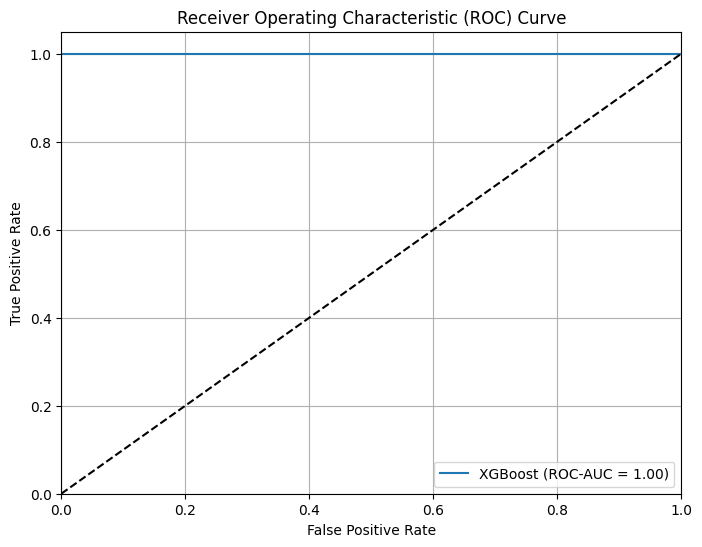

In [837]:
y_pred_proba = cls.predict_proba(X_test)[:, 1]
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (ROC-AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()